In [1]:
import cv2
import os
import numpy as np
from FlagRep import FlagRep
from FlagRep0 import chordal_distance, truncate_svd

from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import tqdm
from skimage.transform import rescale

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

import seaborn as sns

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    
    return accuracies

def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

def load_avi_files(directory):
    avi_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.avi'):
            avi_files.append(os.path.join(directory, filename))
    return avi_files

def read_avi_to_numpy(file_path, coarsen = .03):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    X    = np.array(frames)

    

    # Convert list of frames to a NumPy array
    return X

def concept_plots(file_path, title, coarsen = .03):
    cap = cv2.VideoCapture(file_path)
    if not cap.isOpened():
        print(f"Error opening video file: {file_path}")
        return None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)

    cap.release()

    frame_array = np.array(frames)

    fig, ax = plt.subplots(1,2)
    ax[0].imshow(frame_array[frame_array.shape[0]//2,:,:], cmap = 'grey')
    ax[1].imshow(rescale(frame_array,(1,coarsen,coarsen))[frame_array.shape[0]//2,:,:], cmap = 'grey')

    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()

def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        # print(f"k={k}, Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)
    return accuracies

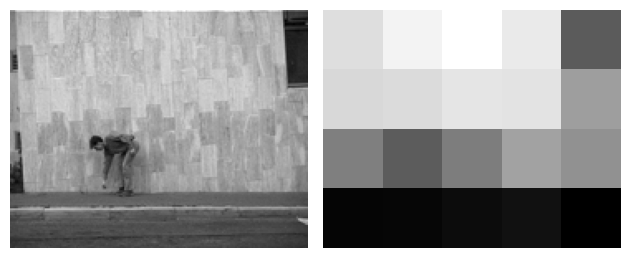

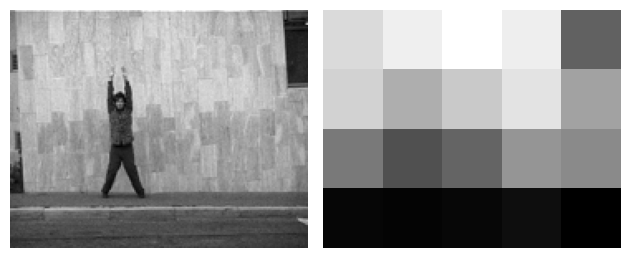

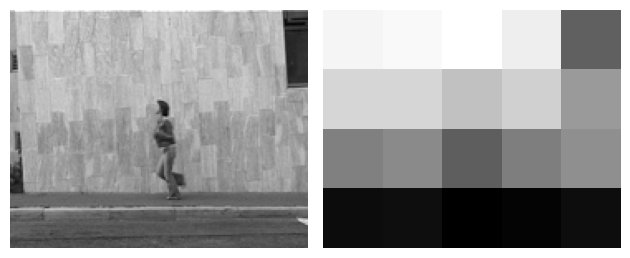

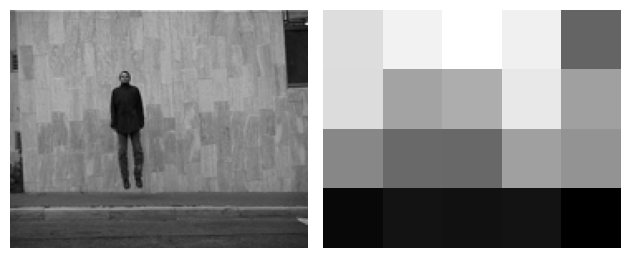

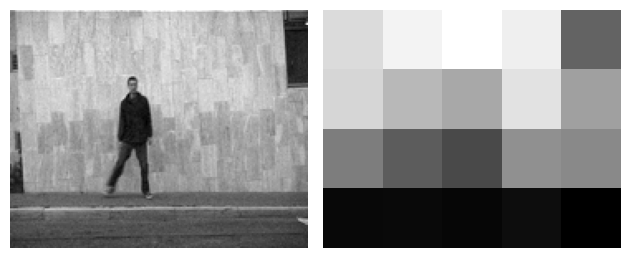

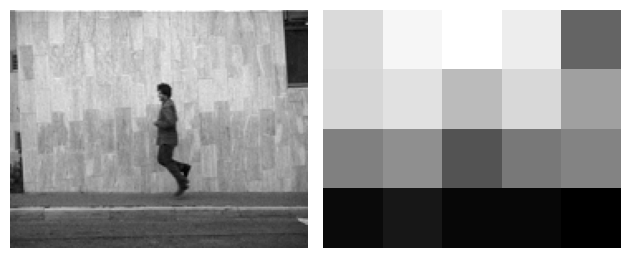

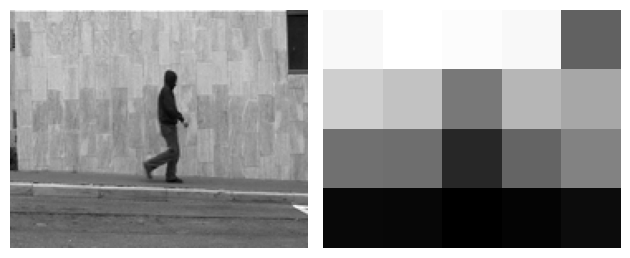

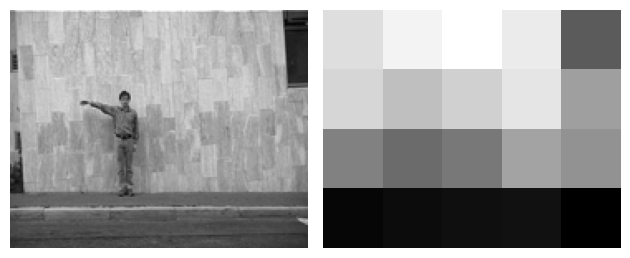

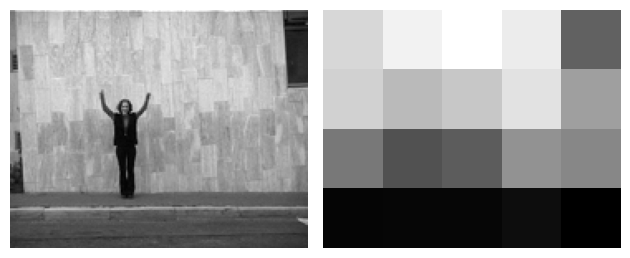

In [2]:


directory = '../data/weizmann/'  # Change to your directory

classes = ['bend', 'jack', 'run', 'pjump', 'side', 'skip', 'walk', 'wave1', 'wave2']


dataset = []
mod_labels = []
for class_name in classes:
    f_path = os.path.join(directory, class_name)
    avi_files = load_avi_files(f_path)
    data = [read_avi_to_numpy(avi_file, .03) for avi_file in avi_files]
    concept_plots(avi_files[0], class_name)
    dataset += data
    mod_labels += [class_name]*len(data)

    

In [3]:
fewest_frame_count = np.min([len(d) for d in dataset])
_,n_rows, n_cols  = dataset[0].shape

trimmed_dataset = []
for d in dataset:
    n_frames = len(d)
    d_trimmed = d[n_frames//2-fewest_frame_count//2:n_frames//2+fewest_frame_count//2,:,:]
    trimmed_dataset.append(d_trimmed)

<Axes: >

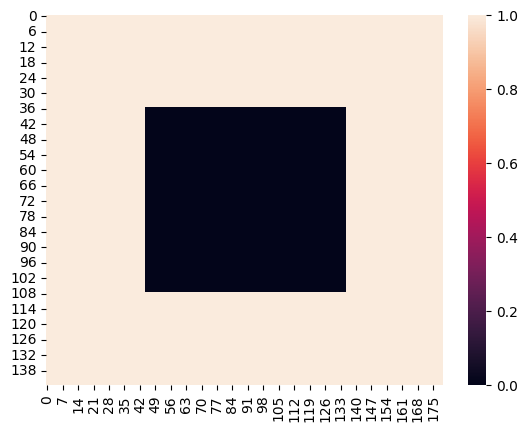

In [4]:
center_row = n_rows//2
center_col = n_cols//2

quarter_row = n_rows//4
quarter_col = n_cols//4

X = []
for d in trimmed_dataset:
    ss1 = d[:,n_rows//4:3*n_rows//4, n_cols//4:3*n_cols//4]
    ss2_mask = np.zeros((n_rows, n_cols), dtype=bool)
    # Set the outer pixels to True
    ss2_mask[:n_rows//4, :] = True  # Top
    ss2_mask[3*n_rows//4:, :] = True  # Bottom
    ss2_mask[:, :n_cols//4] = True  # Left
    ss2_mask[:, 3*n_cols//4+1:] = True  # Right

    
    # plt.axis('off')
    ss2 = d[:,ss2_mask]

    ss1 = ss1.reshape(ss1.shape[0], -1)
    ss2 = ss2.reshape(ss2.shape[0], -1)

    d_flat = np.hstack([ss1,ss2])


    X.append(d_flat)

ss_sizes = [ss1.shape[1], ss2.shape[1]]

sns.heatmap(ss2_mask)

In [5]:
As = [np.arange(len(ss1.T)), np.arange(len(ss1.T)+len(ss2.T))]

In [6]:
Aset = As
eps_rank = .9995

In [15]:

flags = {}
flags['FlagRep'] = []
flags['QR'] = []
flags['SVD'] = []

flag_types = {}
flag_types['FlagRep'] = []
flag_types['QR'] = []
flag_types['SVD'] = []

for m in tqdm.tqdm(X):
    my_flagrep = FlagRep(As, flag_type = [26,27])
    frep = my_flagrep.fit_transform(m)
    frep_ftype = my_flagrep.flag_type()
    flags['FlagRep'].append(frep)
    flag_types['FlagRep'].append(frep_ftype)

    qr ,_= np.linalg.qr(m)
    flags['QR'].append(qr[:,:27])
    flag_types['QR'].append([26,27])

    u = truncate_svd(m)
    flags['SVD'].append(u[:,:2])
    flag_types['SVD'].append([1,2])



100%|██████████| 84/84 [00:03<00:00, 26.71it/s]


In [16]:
m

array([[166, 173, 173, ...,  56,  60,  59],
       [166, 172, 171, ...,  57,  59,  58],
       [165, 172, 169, ...,  56,  57,  58],
       ...,
       [168, 173, 173, ...,  57,  60,  64],
       [167, 172, 172, ...,  56,  61,  59],
       [167, 172, 171, ...,  56,  59,  58]], dtype=uint8)

In [17]:



n_pts = len(flags['FlagRep'])
dist_mats = {}
for method_name in ['FlagRep', 'QR']:
    #make distance matrices
    dist_mats[method_name] = np.zeros((n_pts,n_pts))
    for i in tqdm.tqdm(range(n_pts)):
        for j in range(i+1,n_pts):
            x = flags[method_name][i]
            y = flags[method_name][j]
            fl_type_x = flag_types[method_name][i]
            fl_type_y = flag_types[method_name][j]
            Bs_x = make_Bs(fl_type_x)
            Bs_y = make_Bs(fl_type_y)
            dist = chordal_distance(x, y, Bs_x, Bs_y)
            dist_mats[method_name][i,j] = dist
            dist_mats[method_name][j,i] = dist
            

100%|██████████| 84/84 [00:00<00:00, 740.63it/s]


In [18]:
x, y, n_pts, flags[method_name], method_name

(array([[-1.90847221e-01,  7.26487137e-02,  8.08407187e-02,
         -2.56793752e-02,  1.02064443e-02,  6.11274856e-03,
          2.01571222e-01, -3.81212862e-02, -7.77096510e-02,
         -1.89551764e-03,  1.55247763e-01,  5.75624289e-02,
         -3.43505255e-02,  4.15475932e-02, -6.05207252e-02,
         -1.94551544e-01,  2.23779906e-01, -1.96565920e-01,
         -1.52259211e-02,  3.91740417e-01,  5.98075509e-01,
         -1.58357224e-01,  2.16391840e-02,  3.96448048e-02,
          2.45063239e-01, -2.40491025e-01,  2.57560525e-02],
        [-1.90847221e-01, -1.17833645e-01, -2.76756738e-02,
          1.52359536e-01, -9.97928677e-02, -1.39150936e-01,
          9.16686947e-02,  9.70361493e-02, -7.64573779e-02,
          1.41212542e-01, -1.51865714e-01, -2.36164171e-01,
         -2.21452337e-01, -2.16506347e-01, -2.12346738e-01,
          5.75610974e-02,  1.01908512e-01, -5.07443050e-02,
         -8.23597682e-02,  3.98235143e-02, -5.56018275e-02,
         -8.75475823e-03, -2.53605416e-

/tmp/ipykernel_527380/3649746201.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


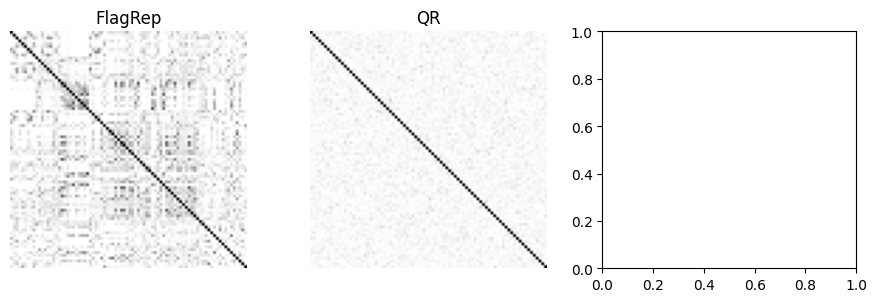

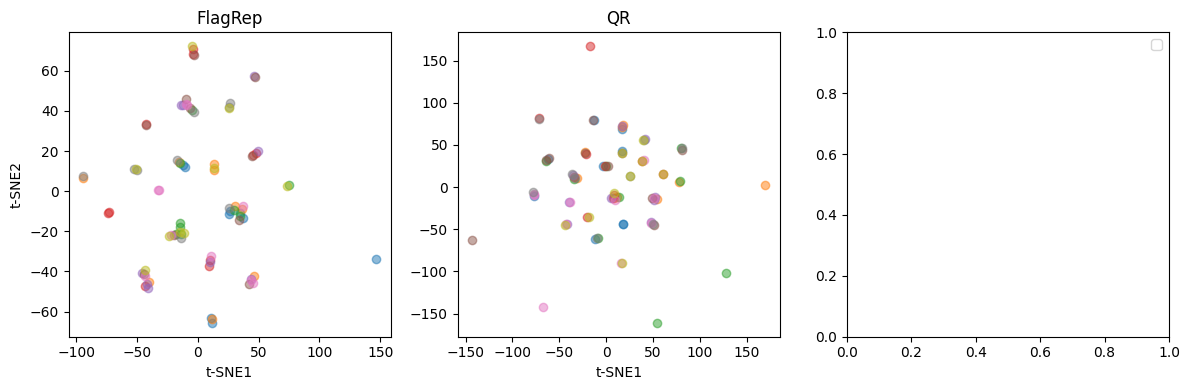

In [19]:
fig,ax = plt.subplots(1,3, figsize = (9,3))

for i, method_name in enumerate(['FlagRep', 'QR']):
    ax[i].set_title(method_name)
    ax[i].imshow(dist_mats[method_name], cmap = 'grey')
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('../results/weizmann_dist_mat.pdf', bbox_inches = 'tight')

fig,ax = plt.subplots(1,3, figsize = (12,4))

for i, method_name in enumerate(['FlagRep', 'QR']):
    tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10, perplexity=np.min([len(dist_mats) - 1, 30]))
    vis_data = tsne.fit_transform(dist_mats[method_name])
    for class_name in np.unique(mod_labels):
        idx = np.where(np.array(mod_labels) == str(class_name))
        scatter = ax[i].scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_name)
    ax[i].set_xlabel('t-SNE1')
    ax[i].set_title(method_name)
ax[0].set_ylabel('t-SNE2')
# Create a legend with labels
plt.legend()
plt.tight_layout()
plt.show()

In [20]:


k_values = np.arange(1,20)
n_trials = 10
indices = np.arange(len(mod_labels))

In [21]:
results = pd.DataFrame(columns = ['k','Method Name', 'Accuracy', 'Seed'])

mod_labels = np.array(mod_labels)
for s in range(n_trials):

    # Step 2: Perform train-test split based on labels using the indices
    train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=s)

    # Step 3: Use these indices to retrieve the corresponding data and labels
    # (This step assumes `data` is an array of the same length as `labels`)
    for method_name in ['FlagRep', 'QR', 'Euclidean']:
        y_train = mod_labels[train_indices]
        y_test = mod_labels[test_indices]
        if method_name == 'Euclidean':
            mod_data = np.vstack([x.flatten() for x in X])
            mod_data_train = mod_data[train_indices, :]
            mod_data_test = mod_data[test_indices,:]
            accs = evaluate_knn(mod_data_train, mod_data_test, y_train, y_test, k_values)
            
        else:
            distance_matrix_train = dist_mats[method_name][train_indices,:][:,train_indices]
            distance_matrix_test = dist_mats[method_name][test_indices,:][:,train_indices]


            # Step 5: Test for different values of k (number of neighbors)

            accs = evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)

        for k, acc in zip(k_values, accs):
            res = pd.DataFrame(columns = results.columns,
                            data = [[k, method_name, acc, s]])
            results = pd.concat([results,res])

k=1, Accuracy: 0.2692
k=2, Accuracy: 0.2692
k=3, Accuracy: 0.3077
k=4, Accuracy: 0.3462
k=5, Accuracy: 0.3077
k=6, Accuracy: 0.2692
k=7, Accuracy: 0.2692
k=8, Accuracy: 0.3462
k=9, Accuracy: 0.2692
k=10, Accuracy: 0.3462
k=11, Accuracy: 0.3077
k=12, Accuracy: 0.2692
k=13, Accuracy: 0.2308
k=14, Accuracy: 0.2308
k=15, Accuracy: 0.2308
k=16, Accuracy: 0.2692
k=17, Accuracy: 0.2692
k=18, Accuracy: 0.2692
k=19, Accuracy: 0.2692
k=1, Accuracy: 0.0769
k=2, Accuracy: 0.1154
k=3, Accuracy: 0.0385
k=4, Accuracy: 0.0769
k=5, Accuracy: 0.1923
k=6, Accuracy: 0.1538
k=7, Accuracy: 0.1923
k=8, Accuracy: 0.0769
k=9, Accuracy: 0.0769
k=10, Accuracy: 0.1154
k=11, Accuracy: 0.1923
k=12, Accuracy: 0.2308
k=13, Accuracy: 0.2308
k=14, Accuracy: 0.2308
k=15, Accuracy: 0.1538
k=16, Accuracy: 0.1538
k=17, Accuracy: 0.1923
k=18, Accuracy: 0.0769
k=19, Accuracy: 0.0385


/tmp/ipykernel_527380/231737011.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,res])


k=1, Accuracy: 0.2692
k=2, Accuracy: 0.3077
k=3, Accuracy: 0.2692
k=4, Accuracy: 0.3462
k=5, Accuracy: 0.3462
k=6, Accuracy: 0.3077
k=7, Accuracy: 0.4231
k=8, Accuracy: 0.3846
k=9, Accuracy: 0.3462
k=10, Accuracy: 0.3846
k=11, Accuracy: 0.3846
k=12, Accuracy: 0.3462
k=13, Accuracy: 0.2308
k=14, Accuracy: 0.2308
k=15, Accuracy: 0.2308
k=16, Accuracy: 0.2692
k=17, Accuracy: 0.2692
k=18, Accuracy: 0.2692
k=19, Accuracy: 0.2692
k=1, Accuracy: 0.1538
k=2, Accuracy: 0.1154
k=3, Accuracy: 0.0769
k=4, Accuracy: 0.1923
k=5, Accuracy: 0.1923
k=6, Accuracy: 0.1923
k=7, Accuracy: 0.1154
k=8, Accuracy: 0.1154
k=9, Accuracy: 0.2308
k=10, Accuracy: 0.2308
k=11, Accuracy: 0.2308
k=12, Accuracy: 0.2692
k=13, Accuracy: 0.2308
k=14, Accuracy: 0.1538
k=15, Accuracy: 0.1538
k=16, Accuracy: 0.1154
k=17, Accuracy: 0.1538
k=18, Accuracy: 0.1538
k=19, Accuracy: 0.1538
k=1, Accuracy: 0.1154
k=2, Accuracy: 0.2308
k=3, Accuracy: 0.2692
k=4, Accuracy: 0.2308
k=5, Accuracy: 0.2692
k=6, Accuracy: 0.3077
k=7, Accurac

([<matplotlib.axis.XTick at 0x729b944d8470>,
 [Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

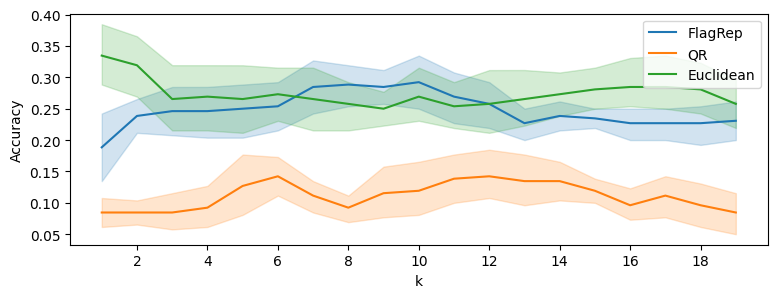

In [22]:
plt.figure(figsize = (9,3))
sns.lineplot(data = results, x = 'k', y = 'Accuracy', hue = 'Method Name')
plt.legend(loc='upper right')
plt.xticks(np.arange(2,k_values[-1]+1,2))
# plt.savefig('../results/weizmann_clustering.pdf', bbox_inches = 'tight')